In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import math

# 4a

In [2]:
# Load in training data and labels
# File available on Canvas

face_data_dict = np.load("face_emotion_data.npz")
face_features = face_data_dict["X"]
face_labels = face_data_dict["y"]
n, p = face_features.shape

# Solve the least - squares solution. weights is the array of weight coefficients
weights = la.inv(face_features.T @ face_features) @ face_features.T @ face_labels

# TODO : find weights
print(f"Part 4a. Found weights:\n{weights}")

Part 4a. Found weights:
[[ 0.94366942]
 [ 0.21373778]
 [ 0.26641775]
 [-0.39221373]
 [-0.00538552]
 [-0.01764687]
 [-0.16632809]
 [-0.0822838 ]
 [-0.16644364]]


# 4b

Suppose the feature points for the new face are given as a vector $x_i = [x_{i1}, ..., x_{i9}]$. We can compute the prediction for the new face by computing $\hat{y_i} = {x_i}^T \cdot w$ where $w$ is the weights vector found earlier. More specifically, we calculate the inner product of $x_i$ and $w$ by finding $x_{i1} \cdot w_1 + ... + x_{i9} \cdot w_9$. Then, we compute $sign(\hat{y_i})$ to get the prediction for the new face, smiling if positive and not smiling if negative.

# 4c

In [3]:
def lstsq_cv_err(
    features: np.ndarray, labels: np.ndarray, subset_count: int = 8
) -> float:
    """Estimate the error of a least-squares classifier
        using cross-validation . Use subset_count different
        train / test splits with each subset acting as the
        holdout set once.

    Parameters:
        features (np.ndarray): dataset features as a 2D
            array with shape (sample_count, feature_count)
        labels (np.ndarray): dataset class labels (+1/-1)
            as a 1D array with length (sample_count)
        subset_count (int): number of subsets to divide the
            dataset into
            Note: assumes that subset_count divides the
                dataset evenly

    Returns:
        cls_err (float): estimated classification error
            rate of least-squares method
    """

    sample_count, feature_count = features.shape
    subset_size = sample_count // subset_count

    # Reshape arrays for easier subset-level manipulation
    features = features.reshape(subset_count, subset_size, feature_count)
    labels = labels.reshape(subset_count, subset_size)

    subset_idcs = np.arange(subset_count)
    train_set_size = (subset_count - 1) * subset_size
    subset_err_counts = np.zeros(subset_count)

    for i in range(subset_count):
        # TODO: select relevant dataset,
        # fit and evaluate a linear model,
        # then store errors in subset_err_counts[i]
        current_features = np.zeros((0, feature_count))
        current_labels = np.zeros((0,))
        for j in range(subset_count):
            if j != i:
                current_features = np.concatenate((current_features, features[j]))
                current_labels = np.concatenate((current_labels, labels[j]))
        hold_out = features[i]
        current_weights = (
            la.inv(current_features.T @ current_features)
            @ current_features.T
            @ current_labels
        )
        predictions = hold_out @ current_weights

        for k in range(subset_size):
            if np.sign(predictions[k]) != np.sign(labels[i][k]):
                subset_err_counts[i] += 1

    # Average over the entire dataset to find the classification error
    cls_err = np.sum(subset_err_counts) / (subset_count * subset_size)
    return cls_err

# Run on the dataset with all features included
full_feat_cv_err = lstsq_cv_err(face_features, face_labels)
print(full_feat_cv_err)
print(f"Error estimate: {full_feat_cv_err*100:.3f}%")

0.046875
Error estimate: 4.688%


# 4d
We find the weights of all 9 features in the least squares estimation. We can let our heuristic be that features with lower weight magnitudes (absolute value of weight) are less important and therefore should be removed first. There are some limitations to this method because a feature with a smaller weight might not necessarily be less important, more that it is scaled appropriately to match the magnitudes of the values for that feature. For example, if feature 1 has small numbers, it could still have high feature importance even with a low weight since the low weight is to account for small inputs, not necessarily for lower importance. Nonetheless, we implement this heuristic since from a glance it appears that most of the data across features have similar sized values.

# 4e

In [4]:
features_by_weights = [[abs(weights[i, 0]), i] for i in range(p)]
features_by_weights.sort(reverse=True)

current_features = [x[1] for x in features_by_weights]
current_error = lstsq_cv_err(face_features, face_labels)

for i in range(p):
    print('features:', current_features)
    print('error:', current_error * 100, '\n')
    current_features.pop()
    current_error = lstsq_cv_err(face_features[:, current_features], face_labels)

features: [0, 3, 2, 1, 8, 6, 7, 5, 4]
error: 4.6875 

features: [0, 3, 2, 1, 8, 6, 7, 5]
error: 4.6875 

features: [0, 3, 2, 1, 8, 6, 7]
error: 4.6875 

features: [0, 3, 2, 1, 8, 6]
error: 4.6875 

features: [0, 3, 2, 1, 8]
error: 5.46875 

features: [0, 3, 2, 1]
error: 7.03125 

features: [0, 3, 2]
error: 7.8125 

features: [0, 3]
error: 8.59375 

features: [0]
error: 7.03125 



Based on the results above, it seems that we should stop removing features once the remaining features are 0, 3, 2, 1, and 8, which gives an error of 5.46875%. Otherwise, if we continue removing features (in this case, the next feature to be removed is feature 8), then our CV accuracy goes above 6%, which we do not want.

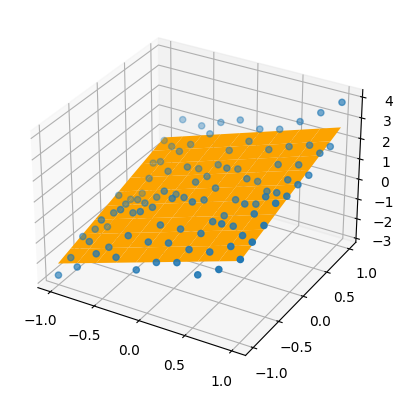

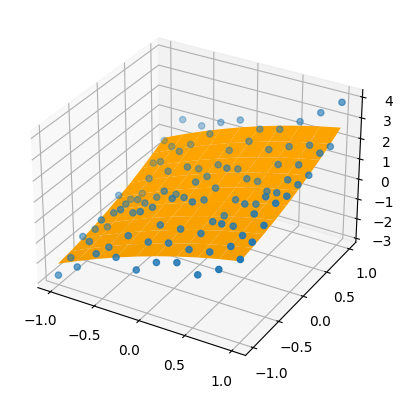

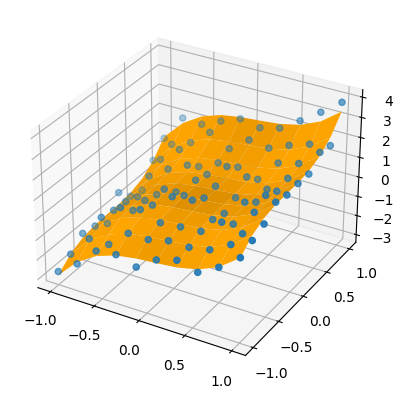

In [5]:
import numpy as np

# File available on Canvas
data = np.load("polydata_2D.npz")
x1 = np.ravel(data["x1"])
x2 = np.ravel(data["x2"])
y = data["y"]

N = x1.size
p = np.zeros((3, N))

for d in [1, 2, 3]:
    # Generate the X matrix for this d
    # Find the least-squares weight matrix w_d
    # Evaluate the best-fit polynomial at each point (x1, x2)
    # and store the result in the corresponding column of p
    X = np.zeros((N, 2 * d + 1))
    for i in range(N):
        X[i, 0] = 1
        for j in range(1, d + 1):
            X[i, j] = math.pow(x1[i], j)
            X[i, j + d] = math.pow(x2[i], j)
    w_d = la.inv(X.T @ X) @ X.T @ y
    p[d - 1] = X @ w_d

# Plot the degree 1 surface
Z1 = p[0, :].reshape(data["x1"].shape)
ax = plt.axes(projection="3d")
ax.scatter(data["x1"], data["x2"], y)
ax.plot_surface(data["x1"], data["x2"], Z1, color="orange")
plt.show()

# Plot the degree 2 surface
Z2 = p[1, :].reshape(data["x1"].shape)
ax = plt.axes(projection="3d")
ax.scatter(data["x1"], data["x2"], y)
ax.plot_surface(data["x1"], data["x2"], Z2, color="orange")
plt.show()

# Plot the degree 3 surface
Z3 = p[2, :].reshape(data["x1"].shape)
ax = plt.axes(projection="3d")
ax.scatter(data["x1"], data["x2"], y)
ax.plot_surface(data["x1"], data["x2"], Z3, color="orange")
plt.show()